In [5]:
# Input:
path_data = '../../01 data/train_pollution.csv'

path_01 = '../../03 outputs/multivariate/01/'
path_scaler = path_01 + 'time_scaler.pickle'
path_x_train = path_01 + 'X_train.npy'
path_y_train = path_01 + 'y_train.npy'
path_x_val = path_01 + 'X_val.npy'
path_y_val = path_01 + 'y_val.npy'
path_x_test = path_01 + 'X_test.npy'
path_y_test = path_01 + 'y_test.npy'

path_x_train_lag4 = path_01 + 'X_train_lag4.npy'
path_x_val_lag4 = path_01 + 'X_val_lag4.npy'
path_y_train_lag4 = path_01 + 'y_train_lag4.npy'
path_y_val_lag4 = path_01 + 'y_val_lag4.npy'
path_x_test_lag4 = path_01 + 'X_test_lag4.npy'
path_y_test_lag4 = path_01 + 'y_test_lag4.npy'

path_02 = '../../03 outputs/multivariate/02/'
path_forecaster_vanilla_lstm = path_02 + 'forecaster_vanilla_lstm.hdf5'
path_forecaster_stacked_lstm = path_02 + 'forecaster_stacked_lstm.hdf5'
path_forecaster_cnn_lstm = path_02 + 'forecaster_cnn_lstm.hdf5'
path_forecaster_conv_lstm = path_02 + 'forecaster_conv_lstm.hdf5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import pickle
from keras.models import load_model

In [51]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
data = data[
    ['date_time', 'target_carbon_monoxide', 'sensor_1', 'sensor_2', 'sensor_5', 'target_benzene', 'target_nitrogen_oxides']
]
print(data.shape)
data.head(3)

(7111, 7)


,date_time,target_carbon_monoxide,sensor_1,sensor_2,sensor_5,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,2.5,1387.2,1087.8,1293.4,12.0,167.7
1,2010-03-10 19:00:00,2.1,1279.1,888.2,1010.9,9.9,98.9
2,2010-03-10 20:00:00,2.2,1331.9,929.6,1117.0,9.2,127.1


In [3]:
# Load data (lag 3 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))
X_test = np.load(open(path_x_test, 'rb'))
y_test = np.load(open(path_y_test, 'rb'))

# Load data (lag 4 steps)
X_train_lag4 = np.load(open(path_x_train_lag4, 'rb'))
y_train_lag4 = np.load(open(path_y_train_lag4, 'rb'))
X_val_lag4 = np.load(open(path_x_val_lag4, 'rb'))
y_val_lag4 = np.load(open(path_y_val_lag4, 'rb'))
X_test_lag4 = np.load(open(path_x_test_lag4, 'rb'))
y_test_lag4 = np.load(open(path_y_test_lag4, 'rb'))

In [10]:
# Load model and tokenizer
scaler = pickle.load(open(path_scaler, 'rb'))

forecaster_vanilla = load_model(path_forecaster_vanilla_lstm)
forecaster_stacked = load_model(path_forecaster_stacked_lstm)
forecaster_cnn = load_model(path_forecaster_cnn_lstm)
forecaster_conv = load_model(path_forecaster_conv_lstm)

In [8]:
def invert_transform_pred(pred, X_):
    # Invert the prediction scaling
    n_features = X_.shape[2]
    inv_X = X_.reshape((X_.shape[0], X_.shape[1] * X_.shape[2]))
    inv_X = np.concatenate((pred, inv_X[:, -n_features+1:]), axis=1)
    inv_X = scaler.inverse_transform(inv_X)
    inv_pred = inv_X[:,0]

    #  Inverse the stationary function (if any)

    return inv_pred

# Vanilla LSTM

In [23]:
# Forecast
pred_train_vanilla = forecaster_vanilla.predict(X_train, verbose=0)
# pred_train_vanilla = invert_transform_pred(pred_train_vanilla, X_train)

In [18]:
y_train.shape

(4620, 1)

In [24]:
pred_train_vanilla.shape

(4620, 3, 1)

# Stacked LSTM

In [27]:
# Forecast train
pred_train_stacked = forecaster_stacked.predict(X_train, verbose=0)
pred_train_stacked = invert_transform_pred(pred_train_stacked, X_train)

# Forecast val
pred_val_stacked = forecaster_stacked.predict(X_val, verbose=0)
pred_val_stacked = invert_transform_pred(pred_val_stacked, X_val)

# Forecast test
pred_test_stacked = forecaster_stacked.predict(X_test, verbose=0)
pred_test_stacked = invert_transform_pred(pred_test_stacked, X_test)

In [52]:
print(pred_train_stacked.shape, pred_val_stacked.shape, pred_test_stacked.shape)

(4620,) (1068,) (1422,)


In [57]:
4620+ 1068+ 1422

7110

In [58]:
print(y_train_lag4.shape, y_val_lag4.shape, y_test_lag4.shape)


(4619, 1) (1068, 1) (1422, 1)


In [55]:
y_train[:5]

array([[ 0.29666993],
       [-0.29071511],
       [-0.54245155],
       [-0.54245155],
       [-0.71027584]])

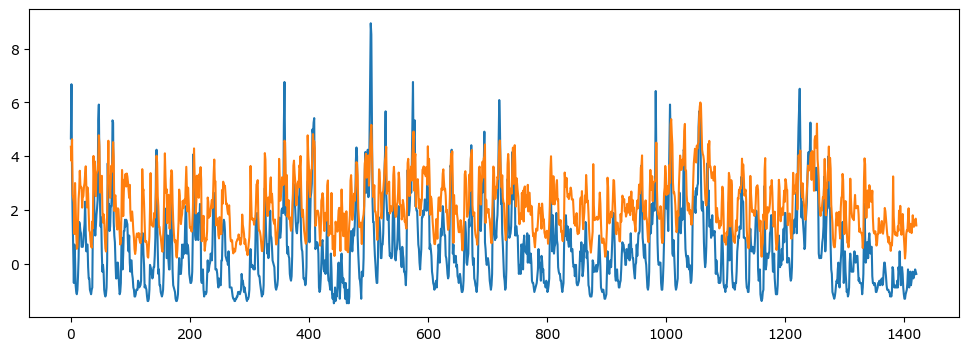

In [46]:
plt.figure(figsize=(12,4))
plt.plot(y_test)
plt.plot(pred_test_stacked)
plt.show()

In [33]:
round(mean_absolute_error(y_val, temp), 3)

0.513